In [1]:
#All  the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, Dropout

2023-05-16 18:04:17.051572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import dataset and combine the image
import zipfile
with zipfile.ZipFile('Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')
# Specify the folder path where the images are located
folder_path = './patch_images/'

# Use glob to get a list of image file paths
image_paths = glob.glob(folder_path + '/*.png')  # Change the extension as per your image file types
df_paths = pd.DataFrame({'Image_Path': image_paths})

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


df_paths['ImageName'] = df_paths['Image_Path'].apply(lambda x: os.path.basename(x))
data_merged_main  = pd.merge(main_data,df_paths, on='ImageName',how='inner')
data_merged_extra = pd.merge(extra_data,df_paths, on='ImageName',how='inner')

data_merged_main.head()


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image_Path
0,22405,1,22405.png,fibroblast,0,0,./patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,./patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,./patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,./patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,./patch_images/22409.png


In [3]:
data_merged_extra.head()

,InstanceID,patientID,ImageName,isCancerous,Image_Path
0,12681,61,12681.png,0,./patch_images/12681.png
1,12682,61,12682.png,0,./patch_images/12682.png
2,12683,61,12683.png,0,./patch_images/12683.png
3,12684,61,12684.png,0,./patch_images/12684.png
4,12685,61,12685.png,0,./patch_images/12685.png


In [4]:
#split the data into 60 20 20
train_data, test_data = train_test_split(data_merged_main , test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data , test_size=0.25, random_state=0)

# train_data, test_data = train_test_split(train_data2, test_size=0.2, random_state=0)
# train_data, val_data = train_test_split(train_data2, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


<h1> Model for CellType<h1>

<h3>Base Model <h3>

In [5]:
#set the parameters
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4
batch_size = 32

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 626,948
Trainable params: 626,948
Non-trainable params: 0
_________________________________________________________________


In [7]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [9]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/var/folders/6y/3ldd75pj46v0c4qyh730qx400000gn/T/ipykernel_10196/2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 18:06:38.312305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 18:06:42.561785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [10]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)

2023-05-16 18:09:26.329590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.8157140612602234
Train Accuracy: 0.6675088405609131


2023-05-16 18:09:28.413822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 0.8233420252799988
Validation Accuracy: 0.6604345440864563


In [11]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

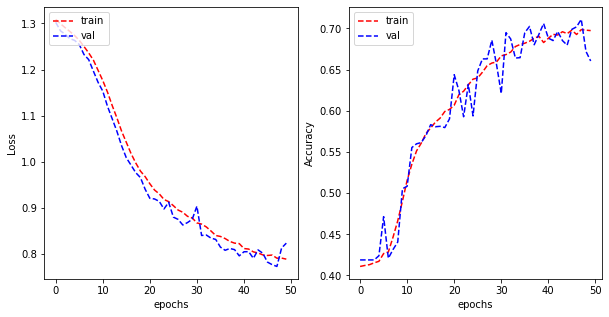

In [12]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [16]:
#test data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size =  1 #batchsize
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size
,
        class_mode='categorical')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Found 1980 validated image filenames belonging to 4 classes.


2023-05-16 18:11:32.049751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.8567742109298706
Test Accuracy: 0.6499999761581421


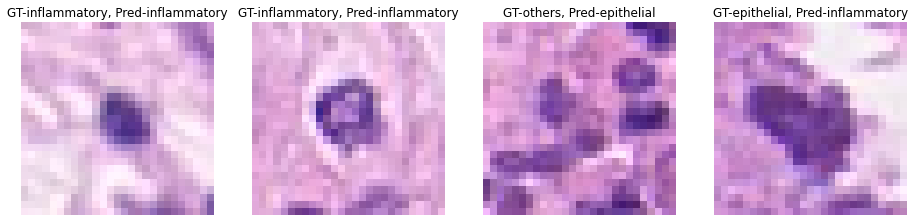

In [17]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

<H1> Incremental Tunning to get the Best Model
<h1>

In [18]:
# #running it one more time
# train_data['cellType'] = train_data['cellType'].astype(str)
# val_data['cellType'] = val_data['cellType'].astype(str)
# test_data['cellType'] = test_data['cellType'].astype(str)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the model architecture
model_2 = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_2.summary()
#learning rate  set at 0.001
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)


#tunning the data generation futhermore
train_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)
val_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)

test_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)
batch_size = 1

train_generator_model_2 = train_dataGen_Model_2.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_model_2 = train_dataGen_Model_2.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator_model_2 = test_dataGen_Model_2.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

epochs = 25 #setting  to  50 for testing
history_1 = model_2.fit(
    train_generator_model_2,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=validation_generator_model_2,
    validation_steps=len(val_data) // batch_size,
    # callbacks=[early_stopping, reduce_lr]
)




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 256)              

2023-05-16 18:14:32.312065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/opt/miniconda3/envs/minimal_ds/lib/python3.9/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5937/5937 [==============================] - ETA: 0s - loss: 1.1008 - categorical_accuracy: 0.5471

2023-05-16 18:15:06.724524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5937/5937 [==============================] - 39s 6ms/step - loss: 1.1008 - categorical_accuracy: 0.5471 - val_loss: 0.9464 - val_categorical_accuracy: 0.6559
Epoch 2/25
5937/5937 [==============================] - 32s 5ms/step - loss: 0.9195 - categorical_accuracy: 0.6310 - val_loss: 0.8053 - val_categorical_accuracy: 0.6857
Epoch 3/25
5937/5937 [==============================] - 31s 5ms/step - loss: 0.8570 - categorical_accuracy: 0.6608 - val_loss: 0.7381 - val_categorical_accuracy: 0.7140
Epoch 4/25
5937/5937 [==============================] - 28s 5ms/step - loss: 0.8225 - categorical_accuracy: 0.6682 - val_loss: 0.7583 - val_categorical_accuracy: 0.6958
Epoch 5/25
5937/5937 [==============================] - 28s 5ms/step - loss: 0.7972 - categorical_accuracy: 0.6870 - val_loss: 0.7411 - val_categorical_accuracy: 0.7201
Epoch 6/25
5937/5937 [==============================] - 33s 6ms/step - loss: 0.7874 - categorical_accuracy: 0.6901 - val_loss: 0.7418 - val_categorical_accuracy: 0.69

In [20]:
train_loss, train_accuracy = model_2.evaluate(train_generator_model_2, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_2.evaluate(validation_generator_model_2, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)


test_loss, test_accuracy = model_2.evaluate(test_generator_model_2, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

2023-05-16 18:27:13.270900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.6470483541488647
Train Accuracy: 0.7392622828483582


2023-05-16 18:27:24.586556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 0.6214926242828369
Validation Accuracy: 0.7478524446487427


2023-05-16 18:27:29.045055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.6607272624969482
Test Accuracy: 0.7303030490875244


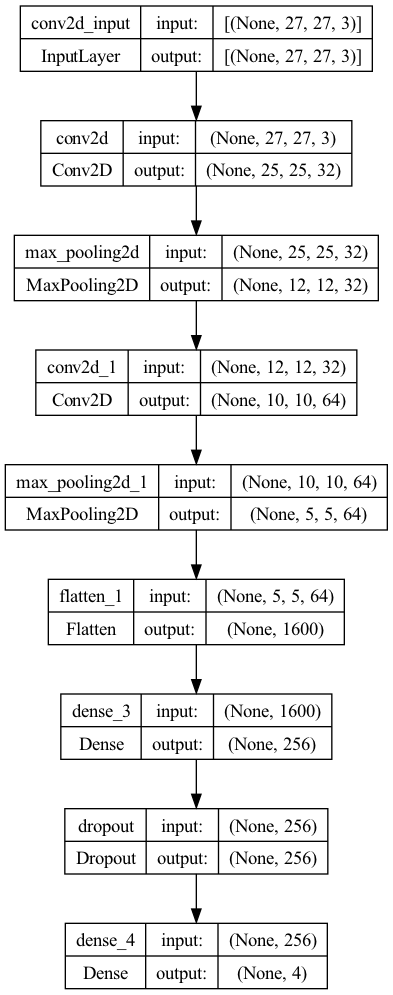

In [21]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

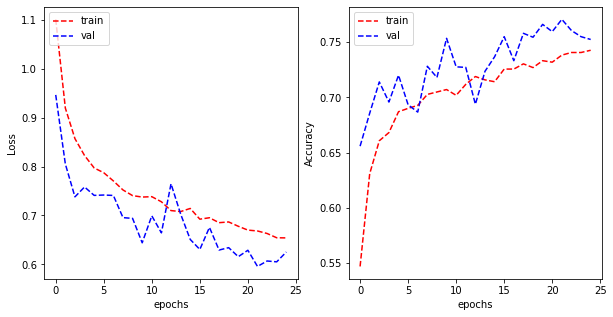

In [22]:
plot_learning_curve(history_1.history['loss'], history_1.history['val_loss'], 
                    history_1.history['categorical_accuracy'], history_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

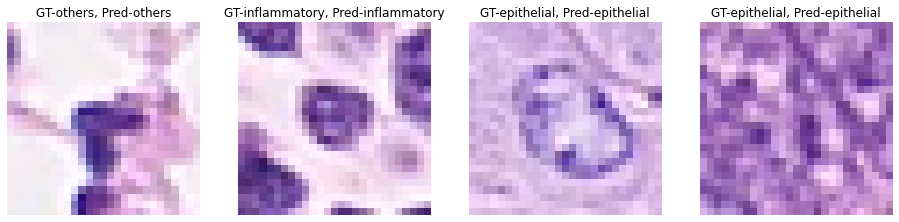

In [23]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_2.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [24]:
model.save("bestModelForCellType")

INFO:tensorflow:Assets written to: bestModelForCellType/assets


INFO:tensorflow:Assets written to: bestModelForCellType/assets


In [27]:
#Unseen data
#unseen data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

unseenData_generator = test_datagen.flow_from_dataframe(
        dataframe=data_merged_extra,#change this line
        directory='./',
        x_col="Image_Path",
        y_col=None,#we are predicting this  
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)#predicting this thats the diffrence from train data

# Load the trained model
best_model = tf.keras.models.load_model('cellType')#this line 

# Make predictions on the unseen data
predictions = best_model.predict(unseenData_generator)


# Process the predictions
predicted_classes = np.argmax(predictions, axis=1)
class_labels = train_generator.class_indices

Found 10384 validated image filenames.
   77/10384 [..............................] - ETA: 13s 

2023-05-16 18:36:50.336087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10384/10384 [==============================] - 16s 2ms/step


In [33]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
reversed_label_names = {v: k for k, v in label_names.items()}

predicted_labels = [reversed_label_names[class_index] for class_index in predicted_classes]


image_filenames = unseenData_generator.filenames


results_df = pd.DataFrame({'Image_Path': image_filenames, 'Predicted_type': predicted_classes, 'Predicted_type_name': predicted_labels})


print(results_df)

results_df.to_csv('unseen_results.csv', index=False)

                     Image_Path  Predicted_type Predicted_type_name
0      ./patch_images/12681.png               2          epithelial
1      ./patch_images/12682.png               1        inflammatory
2      ./patch_images/12683.png               1        inflammatory
3      ./patch_images/12684.png               2          epithelial
4      ./patch_images/12685.png               1        inflammatory
...                         ...             ...                 ...
10379  ./patch_images/20028.png               2          epithelial
10380  ./patch_images/20029.png               2          epithelial
10381  ./patch_images/20030.png               2          epithelial
10382  ./patch_images/20031.png               1        inflammatory
10383  ./patch_images/20032.png               0          fibroblast

[10384 rows x 3 columns]
